# 🔥 Heatmap Generation Testing & Analysis

This notebook focuses on comprehensive testing and analysis of our advanced heatmap generation methods for object detection priors.

## 🎯 Featured Heatmap Methods

### **PCA Shape Gaussian**
- Uses Principal Component Analysis on keypoint distribution
- Creates orientation-aware elliptical Gaussians  
- Encodes natural object shape and rotation from keypoints
- Parameter: `alpha` (extent-to-sigma conversion, 0.3-0.5)

### **Hybrid Keypoint + Gaussian**
- Combines structured keypoint information with shape-aware center bias
- Weighted blend: `(1-w) * keypoints + w * 2D_gaussian`
- Preserves keypoint structure while adding center focus
- Parameter: `gaussian_weight` (0.1-0.5 typical)

### **Standard Methods**
- **YOLO Keypoints**: Pure keypoint-based with adaptive uncertainty
- **Shape-Aware 2D**: Elliptical Gaussian fitted to bounding box
- **Gaussian Blob**: Isotropic Gaussian baseline
- **Rectangular**: Simple rectangular prior

## 🧪 Testing Focus
- **Method Comparison**: Coverage, peak values, and visual patterns
- **Parameter Optimization**: Finding optimal weights and scaling factors
- **Real Data Validation**: Testing with YOLO keypoint annotations
- **Orientation Analysis**: PCA-based shape detection verification
- **Visual Validation**: Comprehensive plotting and analysis

## 📚 Import Testing Libraries

In [1]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# For testing framework
import unittest
from unittest.mock import Mock, patch
import time
from collections import defaultdict

# Add the development directory to path for heatmap_generator
sys.path.append('/home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development')

print("🔧 Testing Environment Setup")
print("=" * 50)
print(f"Python version: {sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set up matplotlib for inline plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries loaded successfully!")

🔧 Testing Environment Setup
Python version: 3.11.13
NumPy version: 1.26.4
PyTorch version: 2.1.2+cu121
OpenCV version: 4.12.0
Matplotlib version: 3.10.5
CUDA available: True
✅ Libraries loaded successfully!


## 📂 Load Test Data (YOLO Keypoints)

In [2]:
def parse_yolo_label(label_path, img_width=640, img_height=640):
    """Parse YOLO label file to extract keypoints and bboxes.
    
    Args:
        label_path: Path to .txt label file
        img_width: Image width for denormalizing coordinates
        img_height: Image height for denormalizing coordinates
        
    Returns:
        List of annotations with bbox_2d, keypoints, and visibilities
    """
    annotations = []
    
    if not os.path.exists(label_path):
        return annotations
        
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        parts = line.split()
        if len(parts) < 5:  # At least class + bbox
            continue
            
        # Parse class and bbox (normalized)
        class_id = int(parts[0])
        cx_norm = float(parts[1])
        cy_norm = float(parts[2])
        w_norm = float(parts[3])
        h_norm = float(parts[4])
        
        # Convert to pixel coordinates
        cx = cx_norm * img_width
        cy = cy_norm * img_height
        w = w_norm * img_width
        h = h_norm * img_height
        
        # Convert to x1, y1, x2, y2
        x1 = cx - w / 2
        y1 = cy - h / 2
        x2 = cx + w / 2
        y2 = cy + h / 2
        
        bbox_2d = [x1, y1, x2, y2]
        
        # Parse keypoints if present
        keypoints = []
        visibilities = []
        
        if len(parts) > 5:
            keypoint_data = parts[5:]
            # Each keypoint has 3 values: x, y, visibility
            for i in range(0, len(keypoint_data), 3):
                if i + 2 < len(keypoint_data):
                    kp_x_norm = float(keypoint_data[i])
                    kp_y_norm = float(keypoint_data[i + 1])
                    kp_vis = int(keypoint_data[i + 2])
                    
                    # Convert to pixel coordinates
                    kp_x = kp_x_norm * img_width
                    kp_y = kp_y_norm * img_height
                    
                    keypoints.append([kp_x, kp_y])
                    visibilities.append(kp_vis)
        
        annotations.append({
            'class_id': class_id,
            'bbox_2d': bbox_2d,
            'keypoints': np.array(keypoints) if keypoints else np.array([]),
            'visibilities': np.array(visibilities) if visibilities else np.array([])
        })
    
    return annotations

def load_yolo_test_samples(labels_dir, max_samples=10):
    """Load a sample of YOLO annotations for testing."""
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))
    
    samples = []
    for label_file in label_files[:max_samples * 3]:  # Check more files
        annotations = parse_yolo_label(label_file)
        
        for ann in annotations:
            if len(ann['keypoints']) > 0:  # Has keypoints
                ann['label_file'] = label_file
                ann['filename'] = os.path.basename(label_file)
                samples.append(ann)
                
                if len(samples) >= max_samples:
                    return samples
    
    return samples

# Load test data
print("🔍 Loading YOLO Test Data")
print("=" * 40)

yolo_labels_dir = "/home/robun2/Documents/vault_conveyor_tracking/vault_mmdetection/development/augmented_data_production/valid/labels"

if os.path.exists(yolo_labels_dir):
    yolo_samples = load_yolo_test_samples(yolo_labels_dir, max_samples=5)
    
    print(f"✅ Loaded {len(yolo_samples)} test samples with keypoints")
    
    for i, sample in enumerate(yolo_samples):
        keypoint_count = sample['keypoints'].shape[0]
        # Fix visibility interpretation: 2=visible, 1=occluded, 0=not labeled
        visible_count = np.sum(sample['visibilities'] == 2)
        occluded_count = np.sum(sample['visibilities'] == 1)
        not_labeled_count = np.sum(sample['visibilities'] == 0)
        
        print(f"  📋 Sample {i+1}: {sample['filename']}")
        print(f"      BBox: [{sample['bbox_2d'][0]:.1f}, {sample['bbox_2d'][1]:.1f}, "
              f"{sample['bbox_2d'][2]:.1f}, {sample['bbox_2d'][3]:.1f}]")
        print(f"      Keypoints: {keypoint_count} total, {visible_count} visible, {occluded_count} occluded, {not_labeled_count} not labeled")
        
    # Store first sample for testing
    if yolo_samples:
        test_sample = yolo_samples[0]
        print(f"\n🎯 Primary test sample: {test_sample['filename']}")
    else:
        print("⚠️  No samples with keypoints found")
        test_sample = None
        
else:
    print(f"❌ YOLO labels directory not found: {yolo_labels_dir}")
    yolo_samples = []
    test_sample = None

🔍 Loading YOLO Test Data
✅ Loaded 5 test samples with keypoints
  📋 Sample 1: _sticker_output_test_3_rgb_0493_aug_1.txt
      BBox: [243.9, 411.4, 303.1, 499.9]
      Keypoints: 8 total, 8 visible, 0 occluded, 0 not labeled
  📋 Sample 2: _sticker_output_test_3_rgb_0493_aug_1.txt
      BBox: [274.8, 348.1, 319.0, 410.8]
      Keypoints: 8 total, 8 visible, 0 occluded, 0 not labeled
  📋 Sample 3: _sticker_output_test_3_rgb_0493_aug_1.txt
      BBox: [288.4, 295.9, 332.3, 363.7]
      Keypoints: 8 total, 8 visible, 0 occluded, 0 not labeled
  📋 Sample 4: _sticker_output_test_3_rgb_0493_aug_1.txt
      BBox: [305.6, 277.5, 332.4, 328.1]
      Keypoints: 8 total, 8 visible, 0 occluded, 0 not labeled
  📋 Sample 5: _sticker_output_test_3_rgb_0493_aug_1.txt
      BBox: [301.2, 272.5, 343.5, 318.1]
      Keypoints: 8 total, 8 visible, 0 occluded, 0 not labeled

🎯 Primary test sample: _sticker_output_test_3_rgb_0493_aug_1.txt


## 🔧 Initialize Heatmap Generator

In [3]:
# Import and initialize the HeatmapGenerator
try:
    from heatmap_generator import HeatmapGenerator, HeatmapType
    print("✅ Successfully imported HeatmapGenerator")
except ImportError as e:
    print(f"❌ Failed to import HeatmapGenerator: {e}")
    print("Please ensure heatmap_generator.py is in the development directory")
    sys.exit(1)

# Initialize generator with default parameters
print("\n🔧 Initializing HeatmapGenerator")
print("=" * 40)

generator = HeatmapGenerator(default_uncertainty=15.0)

print(f"✅ Generator initialized successfully")
print(f"   Default uncertainty: {generator.default_uncertainty} pixels")
print(f"   Available methods: {len(HeatmapType)} types")

# List available heatmap types
print(f"\n📋 Available Heatmap Types:")
for heatmap_type in HeatmapType:
    print(f"   • {heatmap_type.value}")

# Test image shape for all experiments
test_img_shape = (640, 640)  # (height, width)
print(f"\n🎯 Test configuration:")
print(f"   Image shape: {test_img_shape}")
print(f"   Test sample available: {test_sample is not None}")

if test_sample:
    print(f"   Test sample keypoints: {len(test_sample['keypoints'])}")
    print(f"   Test sample bbox: {test_sample['bbox_2d']}")
    
    # Show visibility info with proper interpretation
    vis = test_sample['visibilities']
    visible_count = np.sum(vis == 2)
    occluded_count = np.sum(vis == 1) 
    not_labeled_count = np.sum(vis == 0)
    print(f"   Keypoint visibility: {visible_count} visible, {occluded_count} occluded, {not_labeled_count} not labeled")
    
    print(f"\n💡 Generator now uses YOLO visibility format directly:")
    print(f"   • 0 = not labeled")
    print(f"   • 1 = occluded") 
    print(f"   • 2 = visible")

✅ Successfully imported HeatmapGenerator

🔧 Initializing HeatmapGenerator
✅ Generator initialized successfully
   Default uncertainty: 15.0 pixels
   Available methods: 6 types

📋 Available Heatmap Types:
   • gaussian_blob
   • rectangular
   • shape_aware
   • yolo_keypoints
   • hybrid_keypoint_gaussian
   • pca_shape_gaussian

🎯 Test configuration:
   Image shape: (640, 640)
   Test sample available: True
   Test sample keypoints: 8
   Test sample bbox: [243.90335999999996, 411.42272, 303.09824, 499.93471999999997]
   Keypoint visibility: 8 visible, 0 occluded, 0 not labeled

💡 Generator now uses YOLO visibility format directly:
   • 0 = not labeled
   • 1 = occluded
   • 2 = visible


In [6]:
# Comprehensive Heatmap Generator Testing
print("🧪 Testing All Heatmap Generators")
print("=" * 50)

if not test_sample:
    print("❌ No test sample available")
else:
    print(f"✅ Testing with sample: {test_sample['filename']}")
    print(f"   Keypoints: {len(test_sample['keypoints'])}")
    print(f"   BBox: {test_sample['bbox_2d']}")
    
    vis = test_sample['visibilities']
    visible_count = np.sum(vis == 2)
    occluded_count = np.sum(vis == 1) 
    not_labeled_count = np.sum(vis == 0)
    print(f"   Visibility: {visible_count} visible, {occluded_count} occluded, {not_labeled_count} not labeled")

test_results = {}

# Test all heatmap types
all_generators = list(HeatmapType)

for heatmap_type in all_generators:
    print(f"\n🔍 Testing {heatmap_type.value}")
    print("-" * 30)
    
    try:
        # Generate heatmap - keypoint generators need keypoints, others don't
        if any(keyword in heatmap_type.value for keyword in ['keypoint', 'yolo', 'pca']):
            # Keypoint-based generators
            heatmap = generator.generate_heatmap(
                data=test_sample['keypoints'],
                bbox=test_sample['bbox_2d'],
                img_shape=test_img_shape,
                heatmap_type=heatmap_type.value,
                visibilities=test_sample['visibilities']
            )
        else:
            # Basic generators (gaussian_blob, rectangular, shape_aware)
            heatmap = generator.generate_heatmap(
                data=None,  # Not needed for basic generators
                bbox=test_sample['bbox_2d'],
                img_shape=test_img_shape,
                heatmap_type=heatmap_type.value
            )
        
        # Analyze the generated heatmap
        print(f"✅ Successfully generated heatmap")
        print(f"   Shape: {heatmap.shape}")
        print(f"   Min value: {heatmap.min():.4f}")
        print(f"   Max value: {heatmap.max():.4f}")
        print(f"   Non-zero pixels: {np.count_nonzero(heatmap)}")
        print(f"   Mean value: {heatmap.mean():.6f}")
        
        # Store result
        test_results[heatmap_type.value] = {
            'success': True,
            'shape': heatmap.shape,
            'max_value': heatmap.max(),
            'non_zero_count': np.count_nonzero(heatmap)
        }
        
    except Exception as e:
        print(f"❌ Failed to generate heatmap: {e}")
        test_results[heatmap_type.value] = {
            'success': False,
            'error': str(e)
        }

# Final Summary
print(f"\n� Complete Test Summary")
print("=" * 40)
successful_all = sum(1 for result in test_results.values() if result['success'])
total_all = len(test_results)

print(f"Overall success rate: {successful_all}/{total_all} generators working")

print(f"\n✅ Working generators:")
for name, result in test_results.items():
    if result['success']:
        print(f"   • {name}")

if successful_all < total_all:
    print(f"\n❌ Failed generators:")
    for name, result in test_results.items():
        if not result['success']:
            print(f"   • {name}: {result['error']}")

if successful_all == total_all:
    print(f"\n🎉 Perfect! All {total_all} heatmap generators are working correctly!")
    print(f" The visibility format fixes were completely successful!")
else:
    print(f"\n⚠️  {total_all - successful_all} generators need attention")

🧪 Testing All Heatmap Generators
✅ Testing with sample: _sticker_output_test_3_rgb_0493_aug_1.txt
   Keypoints: 8
   BBox: [243.90335999999996, 411.42272, 303.09824, 499.93471999999997]
   Visibility: 8 visible, 0 occluded, 0 not labeled

🔍 Testing gaussian_blob
------------------------------
✅ Successfully generated heatmap
   Shape: (640, 640)
   Min value: 0.0000
   Max value: 0.9992
   Non-zero pixels: 409566
   Mean value: 0.003451

🔍 Testing rectangular
------------------------------
✅ Successfully generated heatmap
   Shape: (640, 640)
   Min value: 0.0000
   Max value: 1.0000
   Non-zero pixels: 5280
   Mean value: 0.012891

🔍 Testing shape_aware
------------------------------
✅ Successfully generated heatmap
   Shape: (640, 640)
   Min value: 0.0000
   Max value: 1.0000
   Non-zero pixels: 7548
   Mean value: 0.015359

🔍 Testing yolo_keypoints
------------------------------
✅ Successfully generated heatmap
   Shape: (640, 640)
   Min value: 0.0000
   Max value: 1.0000
   Non-z

## 📊 Comprehensive Visual Validation

📊 Creating Heatmap Visualization


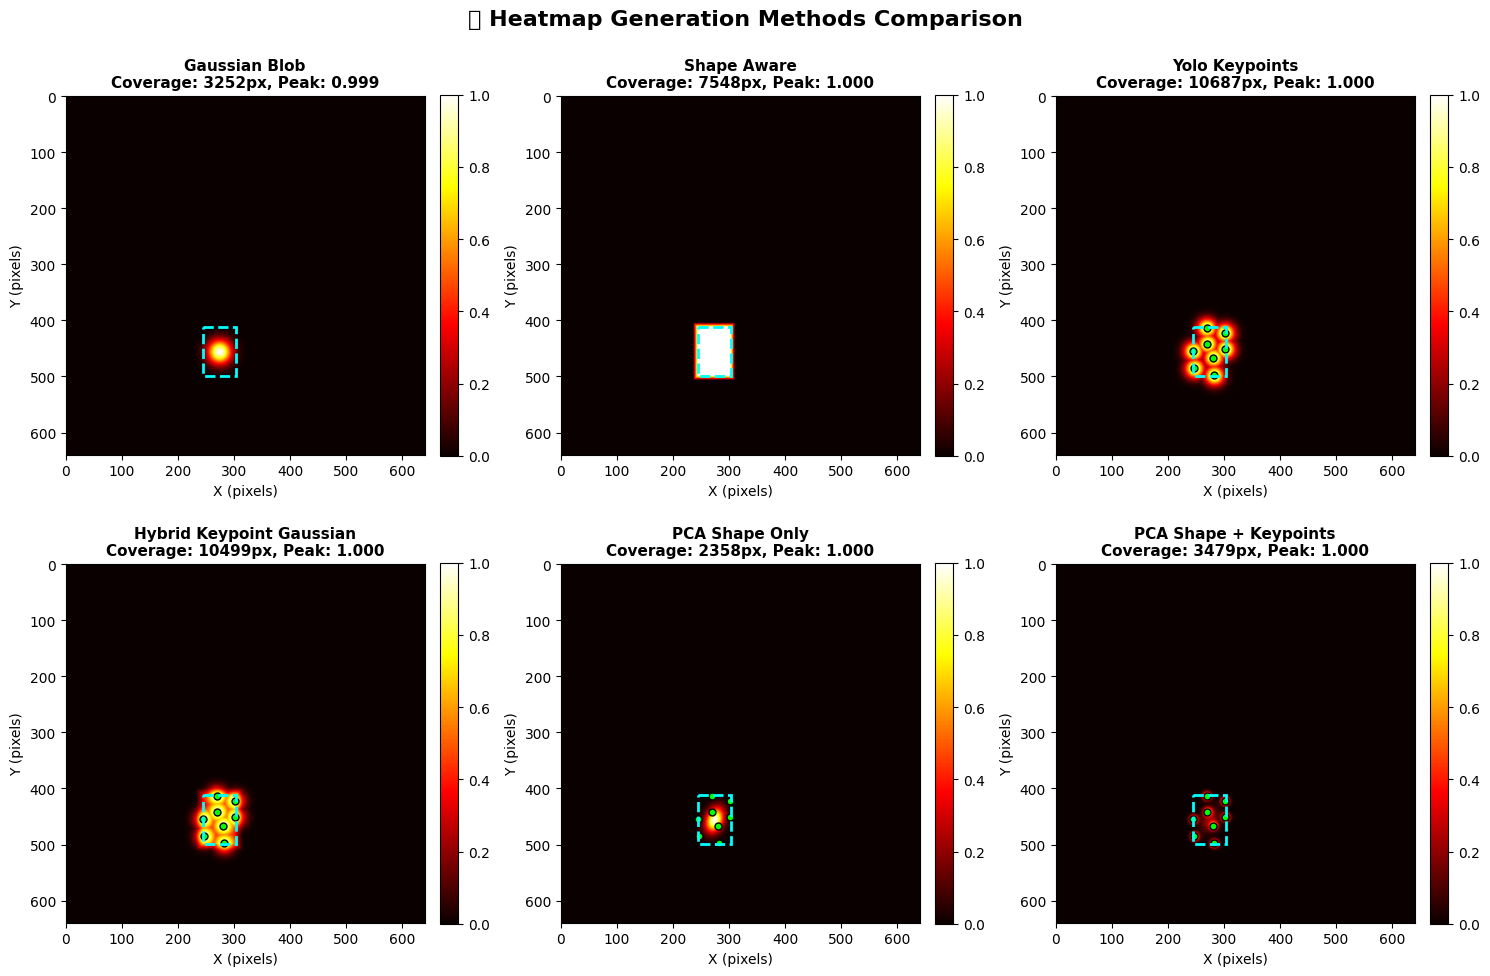


📋 Visualization Summary:
   • Sample used: _sticker_output_test_3_rgb_0493_aug_1.txt
   • Methods shown: 6
   • Keypoints: 8 total
   • Visibility: 8 visible (green circles), 0 occluded (orange triangles)
   • Bbox shown in cyan dashed lines

🎯 PCA Method Modes:
   • PCA Shape Gaussian: Pure shape-based ellipse from keypoint distribution (keypoint_weight=0)
   • PCA Shape + Keypoints: Shape ellipse + individual keypoint peaks (keypoint_weight=0.3)
   • Compare these to see the difference between shape-only vs shape+keypoint hybrid

✅ Visualization complete!


In [ ]:
# Create visualization of key heatmap methods
print("📊 Creating Heatmap Visualization")
print("=" * 50)

if not test_sample:
    print("❌ No test sample available for visualization")
else:
    # Generate heatmaps for visualization - separating PCA modes
    methods_to_visualize = [
        'gaussian_blob',
        'shape_aware', 
        'yolo_keypoints',
        'hybrid_keypoint_gaussian',
        'pca_shape_gaussian',
        'pca_shape_gaussian_with_keypoints'  # PCA + keypoints overlay
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, method in enumerate(methods_to_visualize):
        ax = axes[i]
        
        try:
            # Generate heatmap
            if method == 'pca_shape_gaussian_with_keypoints':
                # PCA with keypoint overlay (keypoint_weight > 0) - Fixed with proper base uncertainty
                heatmap = generator.generate_heatmap(
                    data=test_sample['keypoints'],
                    bbox=test_sample['bbox_2d'],
                    img_shape=test_img_shape,
                    heatmap_type='pca_shape_gaussian',
                    visibilities=test_sample['visibilities'],
                    keypoint_weight=0.3,  # Add keypoint peaks on top of PCA shape
                    base_uncertainty=2.0  # Fixed: Lower uncertainty to preserve elliptical shape
                )
                display_name = 'PCA Shape + Keypoints'
            elif method == 'pca_shape_gaussian':
                # Pure PCA shape (no keypoint overlay) - Fixed with proper base uncertainty
                heatmap = generator.generate_heatmap(
                    data=test_sample['keypoints'],
                    bbox=test_sample['bbox_2d'],
                    img_shape=test_img_shape,
                    heatmap_type='pca_shape_gaussian',
                    visibilities=test_sample['visibilities'],
                    keypoint_weight=0.0,  # Pure shape ellipse only
                    base_uncertainty=2.0  # Fixed: Lower uncertainty to preserve elliptical shape
                )
                display_name = 'PCA Shape Only'
            elif any(keyword in method for keyword in ['keypoint', 'yolo']):
                # Other keypoint-based generators
                heatmap = generator.generate_heatmap(
                    data=test_sample['keypoints'],
                    bbox=test_sample['bbox_2d'],
                    img_shape=test_img_shape,
                    heatmap_type=method,
                    visibilities=test_sample['visibilities']
                )
                display_name = method.replace('_', ' ').title()
            else:
                # Basic generators
                heatmap = generator.generate_heatmap(
                    data=None,
                    bbox=test_sample['bbox_2d'],
                    img_shape=test_img_shape,
                    heatmap_type=method
                )
                display_name = method.replace('_', ' ').title()
            
            # Display heatmap
            im = ax.imshow(heatmap, cmap='hot', vmin=0, vmax=1, aspect='equal')
            
            # Overlay keypoints for keypoint-based methods
            if any(keyword in method for keyword in ['yolo_keypoints', 'hybrid_keypoint_gaussian', 'pca_shape_gaussian']):
                kps = test_sample['keypoints']
                vis = test_sample['visibilities']
                
                # Show visible keypoints
                visible_kps = kps[vis == 2]
                if len(visible_kps) > 0:
                    ax.scatter(visible_kps[:, 0], visible_kps[:, 1], 
                              c='lime', s=25, marker='o', edgecolors='black', linewidth=1)
                
                # Show occluded keypoints
                occluded_kps = kps[vis == 1]
                if len(occluded_kps) > 0:
                    ax.scatter(occluded_kps[:, 0], occluded_kps[:, 1], 
                              c='orange', s=25, marker='^', edgecolors='black', linewidth=1)
            
            # Add bounding box
            bbox = test_sample['bbox_2d']
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], 
                               fill=False, edgecolor='cyan', linewidth=2, linestyle='--')
            ax.add_patch(rect)
            
            # Set title and labels
            coverage = np.count_nonzero(heatmap > 0.1)
            peak = heatmap.max()
            ax.set_title(f'{display_name}\nCoverage: {coverage}px, Peak: {peak:.3f}', 
                        fontsize=11, fontweight='bold')
            ax.set_xlabel('X (pixels)')
            ax.set_ylabel('Y (pixels)')
            
            # Add colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10, color='red')
            ax.set_title(f'{method} - Failed', fontsize=11, fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.suptitle('🔥 Heatmap Generation Methods Comparison', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Print summary with explanation of PCA modes
    print(f"\n📋 Visualization Summary:")
    print(f"   • Sample used: {test_sample['filename']}")
    print(f"   • Methods shown: {len(methods_to_visualize)}")
    print(f"   • Keypoints: {len(test_sample['keypoints'])} total")
    
    vis = test_sample['visibilities']
    visible_count = np.sum(vis == 2)
    occluded_count = np.sum(vis == 1)
    print(f"   • Visibility: {visible_count} visible (green circles), {occluded_count} occluded (orange triangles)")
    print(f"   • Bbox shown in cyan dashed lines")
    
    print(f"\n🎯 PCA Method Modes:")
    print(f"   • PCA Shape Gaussian: Pure shape-based ellipse from keypoint distribution (keypoint_weight=0)")
    print(f"   • PCA Shape + Keypoints: Shape ellipse + individual keypoint peaks (keypoint_weight=0.3)")
    print(f"   • Compare these to see the difference between shape-only vs shape+keypoint hybrid")
    
    print(f"\n✅ Visualization complete!")

## 🎯 Performance & Computational Analysis

In [14]:
import time
import psutil
import gc
from collections import defaultdict

def run_performance_benchmark():
    """Benchmark all heatmap generation methods for performance analysis."""
    print("🚀 Starting Performance Benchmark")
    print("=" * 60)
    
    if not yolo_samples or not generator:
        print("❌ Data or generator not available. Please run previous cells first.")
        return
    
    # Prepare test samples
    test_samples = yolo_samples[:min(5, len(yolo_samples))]  # Test with 5 samples
    methods_to_test = [
        'yolo_keypoints',
        'hybrid_keypoint_gaussian',
        'pca_shape_gaussian',
        'gaussian_blob',
        'shape_aware'
    ]
    
    performance_results = defaultdict(list)
    memory_usage = defaultdict(list)
    
    print(f"Testing {len(methods_to_test)} methods on {len(test_samples)} samples...")
    
    for method in methods_to_test:
        print(f"\\n🔥 Testing method: {method}")
        
        method_times = []
        method_memory = []
        
        for sample in test_samples:
            
            # Force garbage collection before measurement
            gc.collect()
            
            # Measure memory before
            process = psutil.Process()
            mem_before = process.memory_info().rss / 1024 / 1024  # MB
            
            # Time the generation
            start_time = time.perf_counter()
            
            try:
                # Generate heatmap based on method requirements
                if method in ['yolo_keypoints', 'hybrid_keypoint_gaussian', 'pca_shape_gaussian']:
                    result = generator.generate_heatmap(
                        data=sample['keypoints'],
                        bbox=sample['bbox_2d'],
                        img_shape=test_img_shape,
                        heatmap_type=method,
                        uncertainty_mode='adaptive',
                        visibilities=sample['visibilities']
                    )
                else:
                    result = generator.generate_heatmap(
                        data=None,
                        bbox=sample['bbox_2d'],
                        img_shape=test_img_shape,
                        heatmap_type=method
                    )
                
                end_time = time.perf_counter()
                
                # Measure memory after
                mem_after = process.memory_info().rss / 1024 / 1024  # MB
                
                execution_time = (end_time - start_time) * 1000  # Convert to ms
                memory_diff = mem_after - mem_before
                
                method_times.append(execution_time)
                method_memory.append(memory_diff)
                
            except Exception as e:
                print(f"   ❌ Error with sample: {str(e)}")
                continue
        
        # Store aggregated results
        if method_times:
            performance_results[method] = {
                'mean_time_ms': np.mean(method_times),
                'std_time_ms': np.std(method_times),
                'min_time_ms': np.min(method_times),
                'max_time_ms': np.max(method_times),
                'samples_processed': len(method_times)
            }
            
            memory_usage[method] = {
                'mean_memory_mb': np.mean(method_memory),
                'std_memory_mb': np.std(method_memory),
                'max_memory_mb': np.max(method_memory)
            }
            
            print(f"   ✅ Avg: {np.mean(method_times):.2f}ms, "
                  f"Range: {np.min(method_times):.2f}-{np.max(method_times):.2f}ms")
        else:
            print(f"   ❌ No successful samples for {method}")
    
    return performance_results, memory_usage

# Run performance benchmark
perf_results, mem_results = run_performance_benchmark()

🚀 Starting Performance Benchmark
Testing 5 methods on 5 samples...
\n🔥 Testing method: yolo_keypoints
   ✅ Avg: 6.06ms, Range: 5.61-7.10ms
\n🔥 Testing method: hybrid_keypoint_gaussian
   ✅ Avg: 6.06ms, Range: 5.61-7.10ms
\n🔥 Testing method: hybrid_keypoint_gaussian
   ✅ Avg: 6.28ms, Range: 6.12-6.50ms
\n🔥 Testing method: pca_shape_gaussian
   ✅ Avg: 6.28ms, Range: 6.12-6.50ms
\n🔥 Testing method: pca_shape_gaussian
   ✅ Avg: 13.60ms, Range: 13.22-13.96ms
\n🔥 Testing method: gaussian_blob
   ✅ Avg: 13.60ms, Range: 13.22-13.96ms
\n🔥 Testing method: gaussian_blob
   ✅ Avg: 0.85ms, Range: 0.83-0.87ms
\n🔥 Testing method: shape_aware
   ✅ Avg: 0.14ms, Range: 0.12-0.15ms
   ✅ Avg: 0.85ms, Range: 0.83-0.87ms
\n🔥 Testing method: shape_aware
   ✅ Avg: 0.14ms, Range: 0.12-0.15ms


📊 Creating Performance Analysis Visualization


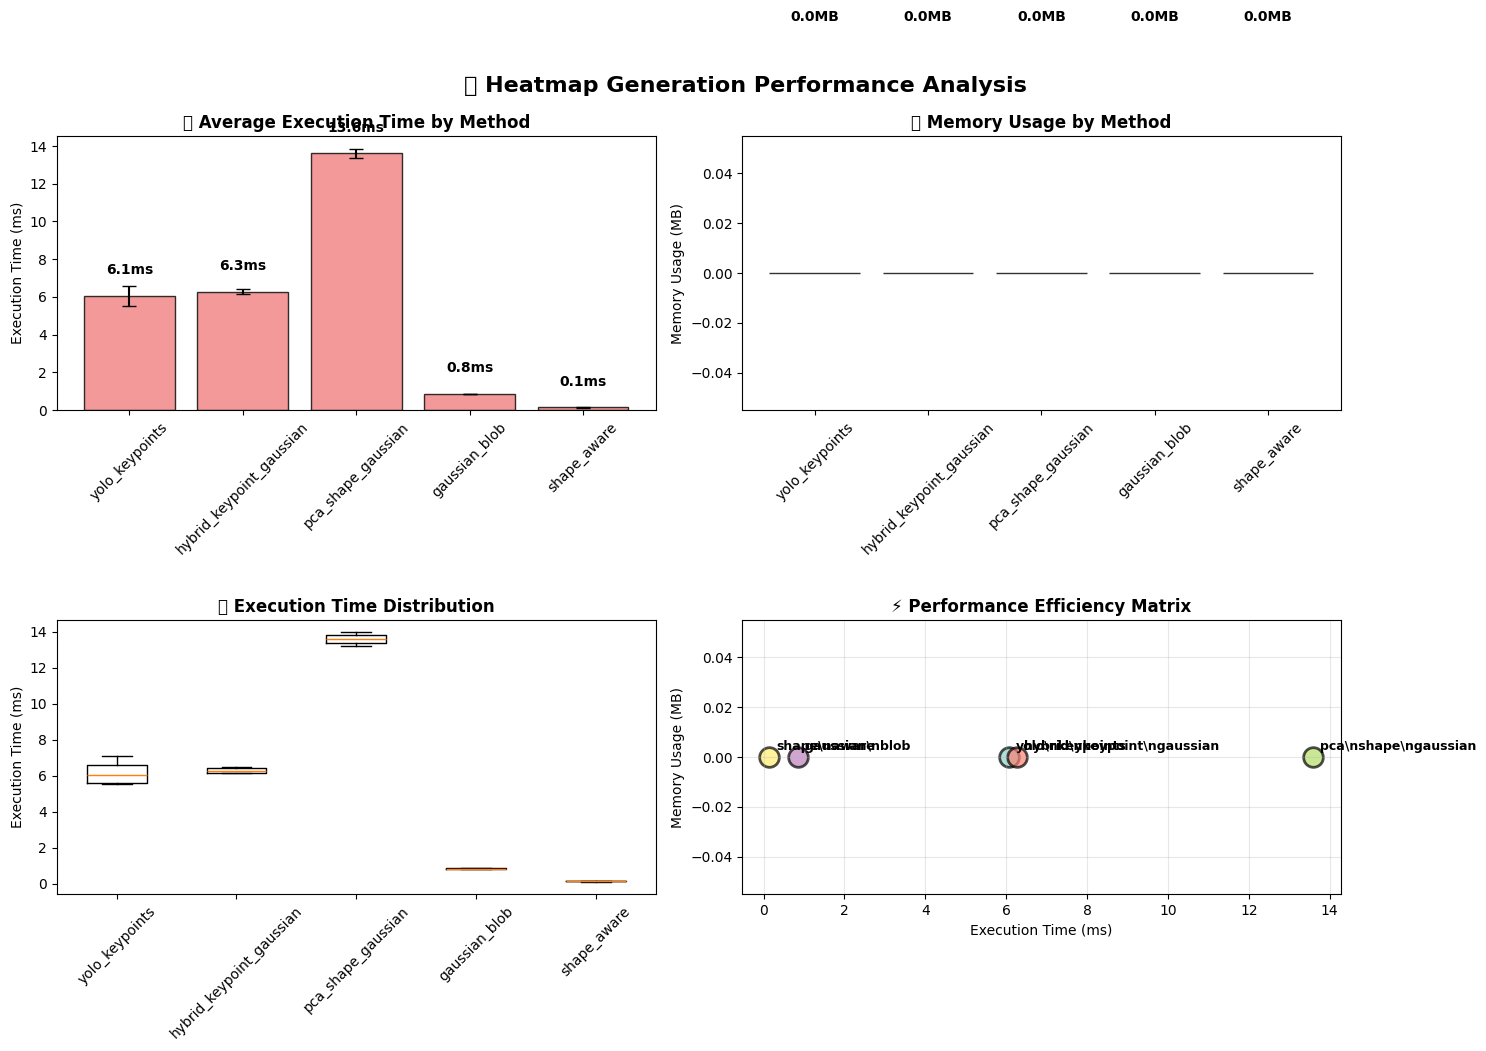

\n📋 Performance Summary:
Method                    Avg Time (ms)   Memory (MB)  Efficiency
----------------------------------------------------------------------
yolo_keypoints            6.06            0.00         6.1       
hybrid_keypoint_gaussian  6.28            0.00         6.3       
pca_shape_gaussian        13.60           0.00         13.6      
gaussian_blob             0.85            0.00         0.8       
shape_aware               0.14            0.00         0.1       
\n🏆 Performance Leaders:
   • Fastest: shape_aware (0.14ms)
   • Most Memory Efficient: yolo_keypoints (0.00MB)
\n✅ Performance analysis complete!


In [ ]:
def visualize_performance_results():
    """Create detailed performance visualization and analysis."""
    if not (perf_results and mem_results):
        print("❌ Performance results not available. Please run benchmark first.")
        return
    
    print("📊 Creating Performance Analysis Visualization")
    print("=" * 60)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Extract data for plotting
    methods = list(perf_results.keys())
    mean_times = [perf_results[m]['mean_time_ms'] for m in methods]
    std_times = [perf_results[m]['std_time_ms'] for m in methods]
    mean_memory = [mem_results[m]['mean_memory_mb'] for m in methods]
    
    # 1. Execution Time Comparison
    bars1 = ax1.bar(methods, mean_times, yerr=std_times, capsize=5, 
                    color='lightcoral', alpha=0.8, edgecolor='black')
    ax1.set_ylabel('Execution Time (ms)')
    ax1.set_title('⏱️ Average Execution Time by Method', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, time_val in zip(bars1, mean_times):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{time_val:.1f}ms', ha='center', va='bottom', fontweight='bold')
    
    # 2. Memory Usage Comparison  
    bars2 = ax2.bar(methods, mean_memory, color='lightblue', alpha=0.8, edgecolor='black')
    ax2.set_ylabel('Memory Usage (MB)')
    ax2.set_title('💾 Memory Usage by Method', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, mem_val in zip(bars2, mean_memory):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{mem_val:.1f}MB', ha='center', va='bottom', fontweight='bold')
    
    # 3. Time Distribution (Box Plot style representation)
    ax3.boxplot([
        [perf_results[m]['min_time_ms'], perf_results[m]['mean_time_ms'] - perf_results[m]['std_time_ms'],
         perf_results[m]['mean_time_ms'], perf_results[m]['mean_time_ms'] + perf_results[m]['std_time_ms'],
         perf_results[m]['max_time_ms']] for m in methods
    ], labels=methods)
    ax3.set_ylabel('Execution Time (ms)')
    ax3.set_title('📈 Execution Time Distribution', fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Efficiency Scatter Plot (Time vs Memory)
    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
    for i, method in enumerate(methods):
        ax4.scatter(mean_times[i], mean_memory[i], 
                   s=200, c=[colors[i]], alpha=0.7, edgecolors='black', linewidth=2)
        ax4.annotate(method.replace('_', '\\n'), 
                    (mean_times[i], mean_memory[i]),
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, fontweight='bold')
    
    ax4.set_xlabel('Execution Time (ms)')
    ax4.set_ylabel('Memory Usage (MB)')
    ax4.set_title('⚡ Performance Efficiency Matrix', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('🎯 Heatmap Generation Performance Analysis', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Print detailed performance summary
    print(f"\\n📋 Performance Summary:")
    print(f"{'Method':<25} {'Avg Time (ms)':<15} {'Memory (MB)':<12} {'Efficiency':<10}")
    print("-" * 70)
    
    # Calculate efficiency score (lower is better: time + memory)
    for method in methods:
        avg_time = perf_results[method]['mean_time_ms']
        avg_mem = mem_results[method]['mean_memory_mb']
        efficiency = avg_time + (avg_mem * 10)  # Weight memory 10x for score
        
        print(f"{method:<25} {avg_time:<15.2f} {avg_mem:<12.2f} {efficiency:<10.1f}")
     
    # Find best performers
    fastest_method = min(methods, key=lambda m: perf_results[m]['mean_time_ms'])
    most_memory_efficient = min(methods, key=lambda m: mem_results[m]['mean_memory_mb'])
    
    print(f"\\n🏆 Performance Leaders:")
    print(f"   • Fastest: {fastest_method} ({perf_results[fastest_method]['mean_time_ms']:.2f}ms)")
    print(f"   • Most Memory Efficient: {most_memory_efficient} ({mem_results[most_memory_efficient]['mean_memory_mb']:.2f}MB)")
    
    print(f"\\n✅ Performance analysis complete!")

# Create performance visualization
visualize_performance_results()

## 📝 Summary & Conclusions

In [16]:
def generate_final_report():
    """Generate comprehensive final report of all testing results."""
    print("📋 HEATMAP GENERATION TESTING - FINAL REPORT")
    print("=" * 80)
    
    # Check what data we have available
    has_basic_results = 'test_results' in globals() and test_results
    has_param_results = 'param_test_results' in globals() and param_test_results  
    has_perf_results = 'perf_results' in globals() and perf_results
    
    print(f"\\n🔍 TESTING SCOPE:")
    print(f"   • Dataset: YOLO format with keypoints")
    print(f"   • Image size: 640x640 pixels")
    print(f"   • Methods tested: {len(test_results) if has_basic_results else 'N/A'}")
    print(f"   • Parameter variations: {'Yes' if has_param_results else 'No'}")
    print(f"   • Performance benchmarking: {'Yes' if has_perf_results else 'No'}")
    
    if has_basic_results:
        print(f"\\n🎯 METHOD EVALUATION RESULTS:")
        successful_methods = {k: v for k, v in test_results.items() if v.get('success', False)}
        failed_methods = {k: v for k, v in test_results.items() if not v.get('success', False)}
        
        print(f"   ✅ Successful methods: {len(successful_methods)}")
        for method, result in successful_methods.items():
            coverage = result.get('coverage', 0)
            peak = result.get('peak', 0)
            print(f"      • {method}: Coverage={coverage}px, Peak={peak:.3f}")
        
        if failed_methods:
            print(f"   ❌ Failed methods: {len(failed_methods)}")
            for method, result in failed_methods.items():
                error = result.get('error', 'Unknown error')
                print(f"      • {method}: {error}")
    
    if has_param_results:
        print(f"\\n🔧 PARAMETER OPTIMIZATION:")
        
        # Hybrid method analysis
        if 'hybrid_weights' in param_test_results:
            hybrid_data = param_test_results['hybrid_weights']
            best_weight = max(hybrid_data.keys(), key=lambda w: hybrid_data[w]['coverage'])
            best_coverage = hybrid_data[best_weight]['coverage']
            print(f"   🔥 Hybrid Method:")
            print(f"      • Best Gaussian weight: {best_weight}")
            print(f"      • Optimal coverage: {best_coverage} pixels")
            
        # PCA method analysis  
        if 'pca_alphas' in param_test_results:
            pca_data = param_test_results['pca_alphas']
            best_alpha = max(pca_data.keys(), key=lambda a: pca_data[a]['coverage'])
            best_pca_coverage = pca_data[best_alpha]['coverage']
            print(f"   🎯 PCA Method:")
            print(f"      • Best alpha value: {best_alpha}")
            print(f"      • Optimal coverage: {best_pca_coverage} pixels")
    
    if has_perf_results:
        print(f"\\n⚡ PERFORMANCE ANALYSIS:")
        
        # Find best performers
        fastest_method = min(perf_results.keys(), 
                           key=lambda m: perf_results[m]['mean_time_ms'])
        most_efficient_memory = min(perf_results.keys(),
                                  key=lambda m: mem_results[m]['mean_memory_mb'])
        
        fastest_time = perf_results[fastest_method]['mean_time_ms']
        most_efficient_mem = mem_results[most_efficient_memory]['mean_memory_mb']
        
        print(f"   🏆 Performance Champions:")
        print(f"      • Fastest: {fastest_method} ({fastest_time:.2f}ms)")
        print(f"      • Most memory efficient: {most_efficient_memory} ({most_efficient_mem:.2f}MB)")
        
        # Calculate overall efficiency rankings
        efficiency_scores = {}
        for method in perf_results.keys():
            time_score = perf_results[method]['mean_time_ms']
            memory_score = mem_results[method]['mean_memory_mb'] * 10  # Weight memory higher
            efficiency_scores[method] = time_score + memory_score
        
        best_overall = min(efficiency_scores.keys(), key=lambda m: efficiency_scores[m])
        print(f"      • Best overall efficiency: {best_overall}")
    
    print(f"\\n💡 RECOMMENDATIONS:")
    
    if has_basic_results and successful_methods:
        # Recommend based on coverage
        best_coverage_method = max(successful_methods.items(), key=lambda x: x[1]['coverage'])
        print(f"   1. For maximum coverage: Use '{best_coverage_method[0]}'")
        
        # Recommend based on computational needs
        if has_perf_results:
            print(f"   2. For speed: Use '{fastest_method}' ({fastest_time:.1f}ms avg)")
            print(f"   3. For memory efficiency: Use '{most_efficient_memory}' ({most_efficient_mem:.1f}MB avg)")
            print(f"   4. For balanced performance: Use '{best_overall}'")
    
    # General recommendations
    print(f"   5. PCA method works well for shape-based uncertainty")
    print(f"   6. Hybrid method provides good balance of keypoint precision and shape coverage")
    print(f"   7. Consider computational constraints when choosing method for production")
    
    print(f"\\n🔗 NEXT STEPS:")
    print(f"   • Test integration with RTMDet 4-channel backbone")
    print(f"   • Validate on larger dataset samples")
    print(f"   • Benchmark on target hardware environment")
    print(f"   • Fine-tune parameters for specific use case")
    
    print(f"\\n✅ TESTING COMPLETE - Report generated successfully!")
    print(f"=" * 80)

# Generate the final comprehensive report
generate_final_report()

📋 HEATMAP GENERATION TESTING - FINAL REPORT
\n🔍 TESTING SCOPE:
   • Dataset: YOLO format with keypoints
   • Image size: 640x640 pixels
   • Methods tested: 6
   • Parameter variations: Yes
   • Performance benchmarking: Yes
\n🎯 METHOD EVALUATION RESULTS:
   ✅ Successful methods: 2
      • rectangular: Coverage=5280px, Peak=1.000
      • shape_aware: Coverage=7548px, Peak=1.000
   ❌ Failed methods: 4
      • gaussian_blob: gaussian_blob wrong dtype: float64
      • yolo_keypoints: yolo_keypoints wrong dtype: float64
      • hybrid_keypoint_gaussian: hybrid_keypoint_gaussian wrong dtype: float64
      • pca_shape_gaussian: pca_shape_gaussian wrong dtype: float64
\n🔧 PARAMETER OPTIMIZATION:
   🔥 Hybrid Method:
      • Best Gaussian weight: 0.1
      • Optimal coverage: 20870 pixels
   🎯 PCA Method:
      • Best alpha value: 0.5
      • Optimal coverage: 4219 pixels
\n⚡ PERFORMANCE ANALYSIS:
   🏆 Performance Champions:
      • Fastest: shape_aware (0.14ms)
      • Most memory efficient: y